# Data Scientist

In [1]:
from src.AriesDuetTokenExchanger import AriesDuetTokenExchanger

%autoawait
import time
import asyncio
import os
import nest_asyncio
from aries_cloudcontroller import AriesAgentController

IPython autoawait is `on`, and set to use `asyncio`


In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")
webhook_port = os.getenv("WEBHOOK_PORT")
webhook_host = "0.0.0.0"

print(
    f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}"
)
scientist_controller = AriesAgentController(admin_url, api_key)

scientist_controller.init_webhook_server(webhook_host, webhook_port)

Initialising a controller with admin api at http://data-scientist-agent:3021 and an api key of datascientistsecretapi


In [3]:
datascientist_exchanger = AriesDuetTokenExchanger(agent_controller=scientist_controller)

REGISTER LISTENERS
Subscribing too: basicmessages
Subscribing too: issue_credential
Subscribing too: connections
Subscribing too: present_proof


## Get Credential from OM Duet Authority Issuer 

Again you should produce this invite through the relevant entrypoint exposed by the OM Authority user interface.

Accepting a connection using the correct invite from the duet issuer will result in the scientists agent being issued a credential from the Duet Issuer which they can use to authenticate with the Data Owner.

Note: The process by which the Data Scientist gets a credential can be designed to provide context specific trust to the use case. They might need to fill out a form, get approval from an ethics committee or prove they are a member of an organisation. The credential acts as a digital attestation to the successful completion of the defined process made by a trustworthy entity.

In [4]:
invite = {
    "@type": "did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation",
    "@id": "e2690b2e-d25a-4783-a349-763ab3276004",
    "label": "OpenMined Duet Authority",
    "recipientKeys": ["79UeKfvYabjXPgqPryYsQA65xJkG2tQUDEF3tMvYTJcx"],
    "serviceEndpoint": "https://d67c71672916.ngrok.io",
}

In [5]:
connection_id = datascientist_exchanger.receive_invitation(invite)

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  09ef1a01-727b-4fb5-ba36-775d103b120f
State :  invitation
Routing State :  none
Their Role :  inviter
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  09ef1a01-727b-4fb5-ba36-775d103b120f
State :  request
Routing State :  none
Their Role :  inviter
----------------------------------------------------------
Connection {'connection_id': '09ef1a01-727b-4fb5-ba36-775d103b120f', 'rfc23_state': 'request-sent', 'their_label': 'OpenMined Duet Authority', 'updated_at': '2021-04-23 05:20:33.241065Z', 'created_at': '2021-04-23 05:20:33.226181Z', 'their_role': 'inviter', 'invitation_key': '79UeKfvYabjXPgqPryYsQA65xJkG2tQUDEF3tMvYTJcx', 'routing_state': 'none', 'accept': 'auto', 'my_did': '6nb3tYLZadZaHWr89dtBoh', 'state': 'request', 'invitation_mode': 'once', 'request_id':

## Configure Duet Server Challenge

This is a aries proof request that is made to every entity who attempts to make a connection with the Duet server. Before receiving the relevant token they must respond with a valid presentation to this request.

Note this challenge could be anything you want, designed to establish context specific trust dependant on the use case. For the challenge to be useful you must be confident that the correct entities will be able to get access to the credential needed to respond. 

In this example case they need a credential based on a schema with this ID `Sgg1wREgfEwbEPCQn9xEuE:2:OM Data Owner:0.0.1`. Getting this credential is easy, entities simply need to connect to the Duet Issuer and will be automatically issued one. An example of a more realistic scenario could include application for research approval from an ethics committee.

In [6]:
schema_id = "Sgg1wREgfEwbEPCQn9xEuE:2:OM Data Owner:0.0.1"


revocation = False
exchange_tracing = False

# Enable this to ask for attributes to identity a user
# TODO - change restriction to schemaId or credentialId

req_attrs = [
    {"name": "domain", "restrictions": [{"schema_id": schema_id}]},
]

global indy_proof_request
indy_proof_request = {
    "name": "Proof of Scientist",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid": req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        #         f"0_{req_pred['name']}_GE_uuid":
        #         req_pred for req_pred in req_preds
    },
}

In [7]:
datascientist_exchanger.configure_challenge(indy_proof_request)

## Join Duet Session

In this instance rather than launching a new Duet server, we are going to join the one created by the Data Owner. Again we pass in a AriesExchanger as the DuetTokenExchanger. This time instead of creating an invitation, the Duet instance requests a invitation be submitted as an input. 

Once this is done, the data scientists agent will establish a connection with the data owner and and authentication policies that were configured will be requested. If successful then the respective parties will communicate their Duet token identifiers over the authenticated DIDComm channel. This will be used to establish a Duet WebRTC connection across with PPML messages can be exchanged.

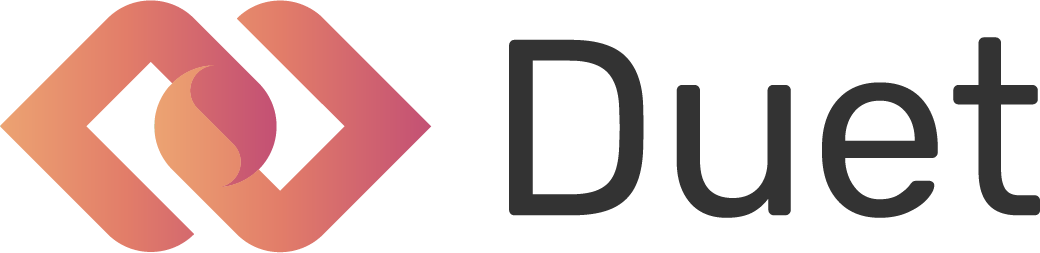

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!


In [ ]:
import syft as sy

duet = sy.join_duet(credential_exchanger=datascientist_exchanger)

## Congratulations!

Once a Duet session has been created, you should be able to run any PPML flows that Duet / PySyft supports. This is left as an excercise for the interested. Do let me know if you run into any problems, but this has been designed so that the authentication layer is not tightly coupled to the Syft flows. Rather it act's as an entrypoint to a PPML flow.

In [ ]:
duet.torch